In [12]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests 
import json
import pandas as pd
import numpy as np

In [17]:
url = "./EMOTIC (1)/EMOTIC/PAMI/emotic/emodb_small/images/4m7t3bsqtw1upazkri.jpg"
url = url.replace("\\", "/")

image = Image.open(url)


In [18]:
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreT

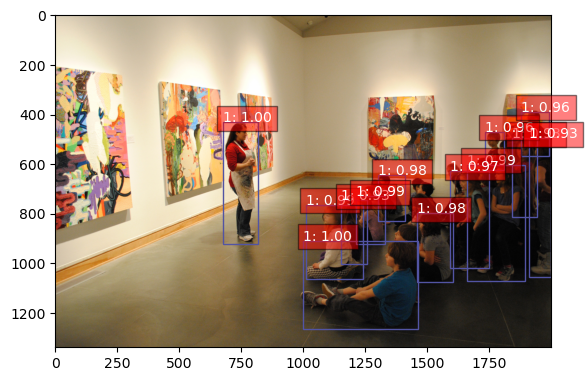

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming `image` is a PIL Image, convert it to display with matplotlib
image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Color map for different classes
color_map = plt.get_cmap('tab20b')

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1,
                             edgecolor=color_map(label % 20), facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(xmin, ymin, f'{label}: {score:.2f}', color='white', 
            bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [26]:
import numpy as np

# Assuming you have already filtered 'person' labels and their corresponding boxes
person_scores = []
person_labels = []
person_boxes = []

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if model.config.id2label[label.item()] == 'person':
        person_labels.append(label)
        person_boxes.append(box)
        person_scores.append(score.item())  # Store scores for sorting

# Now sort person_scores and use the sorted indices to sort person_labels and person_boxes
sorted_indices = np.argsort(person_scores)[::-1]  # [::-1] for descending order

sorted_person_labels = [person_labels[i] for i in sorted_indices]
sorted_person_boxes = [person_boxes[i] for i in sorted_indices]
sorted_person_scores = [person_scores[i] for i in sorted_indices]


sorted_results = {
    "scores": sorted_person_scores,
    "labels": sorted_person_labels,
    "boxes": sorted_person_boxes
}

bboxes = [[int(x) for x in bbox] for bbox in sorted_results["boxes"]]
bboxes[:5]



[[675, 430, 817, 920],
 [999, 908, 1464, 1263],
 [1659, 601, 1895, 1072],
 [1009, 764, 1241, 1063],
 [1211, 728, 1331, 922]]

In [53]:
def model_results(img):

    image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
    inputs = image_processor(images=img, return_tensors="pt")
    outputs = model(**inputs)

    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=torch.tensor([img.size[::-1]]))[0]

    person_scores = []
    person_labels = []
    person_boxes = []

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == 'person':
            person_labels.append(label)
            person_boxes.append(box)
            person_scores.append(score.item())  

    # Sorting the results by score
    sorted_indices = np.argsort(person_scores)[::-1]  

    sorted_person_labels = [person_labels[i] for i in sorted_indices]
    sorted_person_boxes = [person_boxes[i] for i in sorted_indices]
    sorted_person_scores = [person_scores[i] for i in sorted_indices]


    sorted_results = {
        "scores": sorted_person_scores,
        "labels": sorted_person_labels,
        "boxes": sorted_person_boxes
    }

    bboxes = [[int(x) for x in bbox] for bbox in sorted_results["boxes"]]
    bboxes = bboxes[:15]
    
    return bboxes

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    # determine the coordinates of the intersection rectangle
    xA = max(x1, x1g)
    yA = max(y1, y1g)
    xB = min(x2, x2g)
    yB = min(y2, y2g)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (x2 - x1 + 1) * (y2 - y1 + 1)
    boxBArea = (x2g - x1g + 1) * (y2g - y1g + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def get_iou(bbox1, bbox2, thresh, new_annots = []):
    iou_score = iou(bbox1, bbox2)
    if iou_score > thresh:
        new_annots.append(bbox1)
        #new_annots.append(bbox2)
    else:
        new_annots.append(bbox1)
        new_annots.append(bbox2)
    return new_annots

def remove_duplicates(lst):
    return [list(t) for t in {tuple(item) for item in lst}]


In [58]:
url = "EMOTIC (1)\EMOTIC\PAMI\emotic/mscoco/images/COCO_val2014_000000562243.jpg"
url = url.replace("\\", "/")

image = Image.open(url)

bboxes = model_results(image)
image_id = 562243
list_appair = []
new_bbox = []
list_appair.append({'id': image_id, 'bboxes': bboxes})

new_annotations = []
train_annots = [{"image_id": 0, "id": 0, "category_id": 1, "bbox": [83, 63, 564, 637], 
                 "coco_ids": {"image_id": 562243, "annotations_id": 448867}, 
                 "annotations_categories": ["Disconnection", "Doubt/Confusion"], 
                 "annotations_continuous": {"valence": 5, "arousal": 3, "dominance": 9}, 
                 "gender": "Male", "age": "Adult"}, 
                 {"image_id": 0, "id": 1, "category_id": 1, "bbox": [295, 347, 382, 639], 
                  "coco_ids": {"image_id": 562243, "annotations_id": 448867}, 
                  "annotations_categories": ["Disconnection", "Doubt/Confusion"], 
                  "annotations_continuous": {"valence": 5, "arousal": 3, "dominance": 9}, 
                  "gender": "Male", "age": "Adult"}, 
                  {"image_id": 0, "id": 2, "category_id": 1, "bbox": [86, 58, 564, 628], 
                   "coco_ids": {"image_id": 562243, "annotations_id": 448867}, 
                   "annotations_categories": ["Disconnection", "Doubt/Confusion"], 
                   "annotations_continuous": {"valence": 5, "arousal": 3, "dominance": 9}, 
                   "gender": "Male", "age": "Adult"}]

old_bbx = [[83, 63, 564, 637], [295, 347, 382, 639], [86, 58, 564, 628]]
print(bboxes)
print(old_bbx)
for single_bbox in old_bbx:
    for bbox2 in bboxes:
        get_iou(single_bbox, bbox2, 0.8, new_bbox)
new_bbox = remove_duplicates(new_bbox)
print(new_bbox)
    


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreT

[[83, 63, 564, 637]]
[[83, 63, 564, 637], [295, 347, 382, 639], [86, 58, 564, 628]]
[[295, 347, 382, 639], [83, 63, 564, 637], [86, 58, 564, 628]]


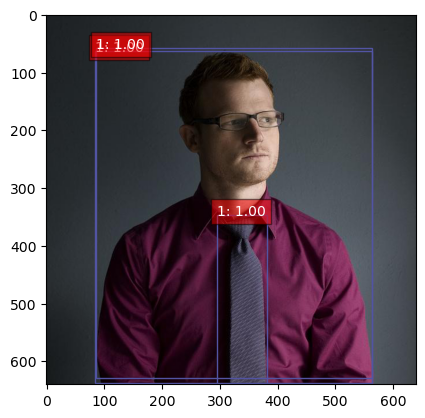

In [59]:
# Assuming `image` is a PIL Image, convert it to display with matplotlib
image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Color map for different classes
color_map = plt.get_cmap('tab20b')

for box in new_bbox:
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1,
                             edgecolor=color_map(label % 20), facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(xmin, ymin, f'{label}: {score:.2f}', color='white', 
            bbox=dict(facecolor='red', alpha=0.5))

plt.show()

# Model prestation


In [98]:
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    # determine the coordinates of the intersection rectangle
    xA = max(x1, x1g)
    yA = max(y1, y1g)
    xB = min(x2, x2g)
    yB = min(y2, y2g)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (x2 - x1 + 1) * (y2 - y1 + 1)
    boxBArea = (x2g - x1g + 1) * (y2g - y1g + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def get_iou(bbox1, bbox2, thresh, new_annots = []):
    iou_score = iou(bbox1, bbox2)
    if iou_score > thresh:
        new_annots.append(bbox1)
        #new_annots.append(bbox2)
    else:
        new_annots.append(bbox1)
        new_annots.append(bbox2)
    return new_annots

def model_results(img):
   
    image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
    inputs = image_processor(images=img, return_tensors="pt")
    outputs = model(**inputs)

    results = image_processor.post_process_object_detection(outputs, threshold=0.95, target_sizes=torch.tensor([img.size[::-1]]))[0]

    person_scores = []
    person_labels = []
    person_boxes = []

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == 'person':
            person_labels.append(label)
            # Ensure the box is detached before any manipulation
            person_boxes.append(box.detach())
            person_scores.append(score.item())

    # Sorting the results by score
    sorted_indices = np.argsort(person_scores)[::-1]

    sorted_person_labels = [person_labels[i] for i in sorted_indices]
    sorted_person_boxes = [person_boxes[i] for i in sorted_indices]
    sorted_person_scores = [person_scores[i] for i in sorted_indices]

    # Calculating area for sorting requires detaching and converting to numpy, which is already done for boxes
    areas = [box[2].item() * box[3].item() for box in sorted_person_boxes]
    sorted_indices = np.argsort(areas)[::-1]

    sorted_person_labels = [sorted_person_labels[i] for i in sorted_indices]
    sorted_person_boxes = [sorted_person_boxes[i] for i in sorted_indices]
    sorted_person_scores = [sorted_person_scores[i] for i in sorted_indices]

    sorted_results = {
        "scores": sorted_person_scores,
        "labels": sorted_person_labels,
        "boxes": sorted_person_boxes
    }

    bboxes = [[int(x.item()) for x in bbox] for bbox in sorted_results["boxes"]]
    bboxes = bboxes[:25]
    
    last_bboxes = []
    for box1 in bboxes:
        for box2 in bboxes:
            get_iou(box1, box2, 0.8, last_bboxes)
    last_bboxes = remove_duplicates(last_bboxes)
    
    return last_bboxes


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreT

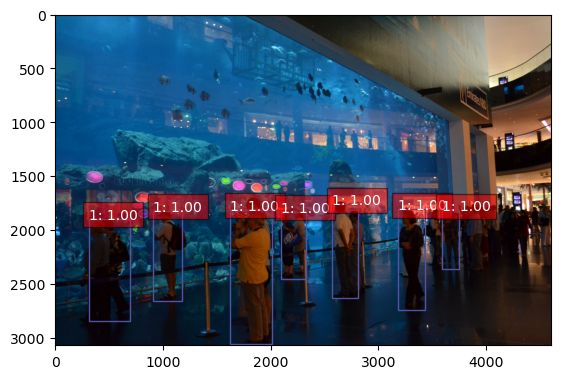

[[311, 1896, 692, 2849],
 [3182, 1806, 3433, 2741],
 [3593, 1817, 3753, 2364],
 [1624, 1812, 2012, 3058],
 [2095, 1832, 2328, 2456],
 [2574, 1763, 2810, 2636],
 [912, 1821, 1181, 2658]]

In [100]:
url = "EMOTIC (1)\EMOTIC\PAMI\emotic\/framesdb\images\\frame_0clx8zgnq849lkze.jpg"
url = url.replace("\\", "/")

image = Image.open(url)

bboxes = model_results(image)

image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Color map for different classes
color_map = plt.get_cmap('tab20b')

for box in bboxes:
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1,
                             edgecolor=color_map(label % 20), facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(xmin, ymin, f'{label}: {score:.2f}', color='white', 
            bbox=dict(facecolor='red', alpha=0.5))

plt.show()
bboxes